![image.png](https://i.imgur.com/a3uAqnb.png)

In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install numpy
%pip install matplotlib
%pip install torchvision

clear_output()

Note: We're using torch modules (datasets, dataloaders) to download dataset and easily make batches. The NN will be made in numpy and every step will be implemented ourselves

In [3]:
import numpy as np

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from torchvision.transforms.functional import to_tensor

import matplotlib.pyplot as plt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
import seaborn as sns
import pandas as pd
from sklearn import datasets, utils

#Play ground

In [5]:
#@title Loss landscape
#generate synthetic data for linear regression
np.random.seed(42)
noise = np.random.randn(100, 1)
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + noise #true equation we are trying to approximate

#function to calculate the Mean Squared Error (MSE)
def mse_cost(w, b, X, y):
    m = len(X)
    predictions = w * X + b
    return (1/(2*m)) * np.sum((predictions - y) ** 2)

#function to create a 3D plot of the MSE cost
def plot_mse(w=0, b=0):
    w_values = np.linspace(-1, 7, 100)
    b_values = np.linspace(-1, 7, 100)
    W, B = np.meshgrid(w_values, b_values)

    #calculate the MSE cost for each combination of w and b
    Z = np.array([[mse_cost(w, b, X, y) for w in w_values] for b in b_values])

    #create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(W, B, Z, cmap='viridis', alpha=0.6)

    # Plot the point corresponding to the current w and b
    cost = mse_cost(w, b, X, y)
    ax.scatter(w, b, cost, color='red', s=50)

    ax.set_xlabel('w')
    ax.set_ylabel('b')
    ax.set_zlabel('MSE Cost')
    ax.set_title('MSE Cost Function')

    plt.show()

    #print the current cost
    print(f"At w={w:.2f}, b={b:.2f}, the MSE cost is {cost:.4f}")

#interactive plot with sliders for w and b
interact(plot_mse, w=(-1.0, 7.0, 0.1), b=(-1.0, 7.0, 0.1));

interactive(children=(FloatSlider(value=0.0, description='w', max=7.0, min=-1.0), FloatSlider(value=0.0, descr…

In [6]:
#@title Gradient Descent
# function to compute the gradients of the cost function
def compute_gradients(w, b, X, y):
    m = len(X)
    predictions = w * X + b
    dw = (2/m) * np.sum((predictions - y) * X)
    db = (2/m) * np.sum(predictions - y)
    return dw, db

#function to perform gradient descent and plot the steps
def gradient_descent_plot(alpha=0.1, steps=10):
  #random initialization step 1
    w_values = np.linspace(-1, 7, 100)
    b_values = np.linspace(-1, 7, 100)
    W, B = np.meshgrid(w_values, b_values)

    # Calculate the MSE cost for each combination of w and b
    # compute preds step 2
    Z = np.array([[mse_cost(w, b, X, y) for w in w_values] for b in b_values])

    #initialize w and b
    w, b = 0, 0

    #store the path of gradient descent
    #compute cost step 3
    w_path, b_path, cost_path = [w], [b], [mse_cost(w, b, X, y)]

    #perform gradient descent
    # compute gradients step 4
    for _ in range(steps):
        dw, db = compute_gradients(w, b, X, y)

        #weights update step 5
        w -= alpha * dw
        b -= alpha * db

        #store each step
        w_path.append(w)
        b_path.append(b)
        cost_path.append(mse_cost(w, b, X, y))

    #create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(W, B, Z, cmap='viridis', alpha=0.6)

    #plot the path of gradient descent
    ax.plot(w_path, b_path, cost_path, color='red', marker='o', markersize=5)

    ax.set_xlabel('w')
    ax.set_ylabel('b')
    ax.set_zlabel('MSE Cost')
    ax.set_title('Gradient Descent on MSE Cost Function')

    plt.show()

    #print the final parameters and cost
    print(f"Final w={w:.2f}, b={b:.2f}, with MSE cost = {cost_path[-1]:.4f}")

#interactive plot with sliders for learning rate and number of steps
interact(gradient_descent_plot, alpha=(0.01, 1.0, 0.01), steps=(1, 100, 1));

interactive(children=(FloatSlider(value=0.1, description='alpha', max=1.0, min=0.01, step=0.01), IntSlider(val…

#Contents:

1. Implementation of 2 layer NN from scratch using numpy which classifies MNIST dataset

About MNIST:

the dataset consists of images of 28x28 size. The image each contains a handwritten digit from 0 to 9. Our model needs to take this image and classify it to the correct digit.


You need to know:

1. **numpy** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader (details of the functions is given anyways)

In [9]:
# MNIST function fetches the MNIST dataset. Without any transform param, the returned object is a Pillow image but we want to convert it to numerical form
# that is to say, a numpy array/torch tensor

# to_tensor is used to avoid errors when creating data loader later. we'll convert them to numpy arrays when the time comes
train_data = MNIST(root='./datasets', train=True, download=True, transform=to_tensor)
test_data  = MNIST(root='./datasets', train=True, download=True, transform=to_tensor)

clear_output()

In [10]:
batch_size = 64

# Dataloaders are used to easily create batches of data so we can perform batch gradient descent for faster learning
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Here's how our 2 layer NN will work.

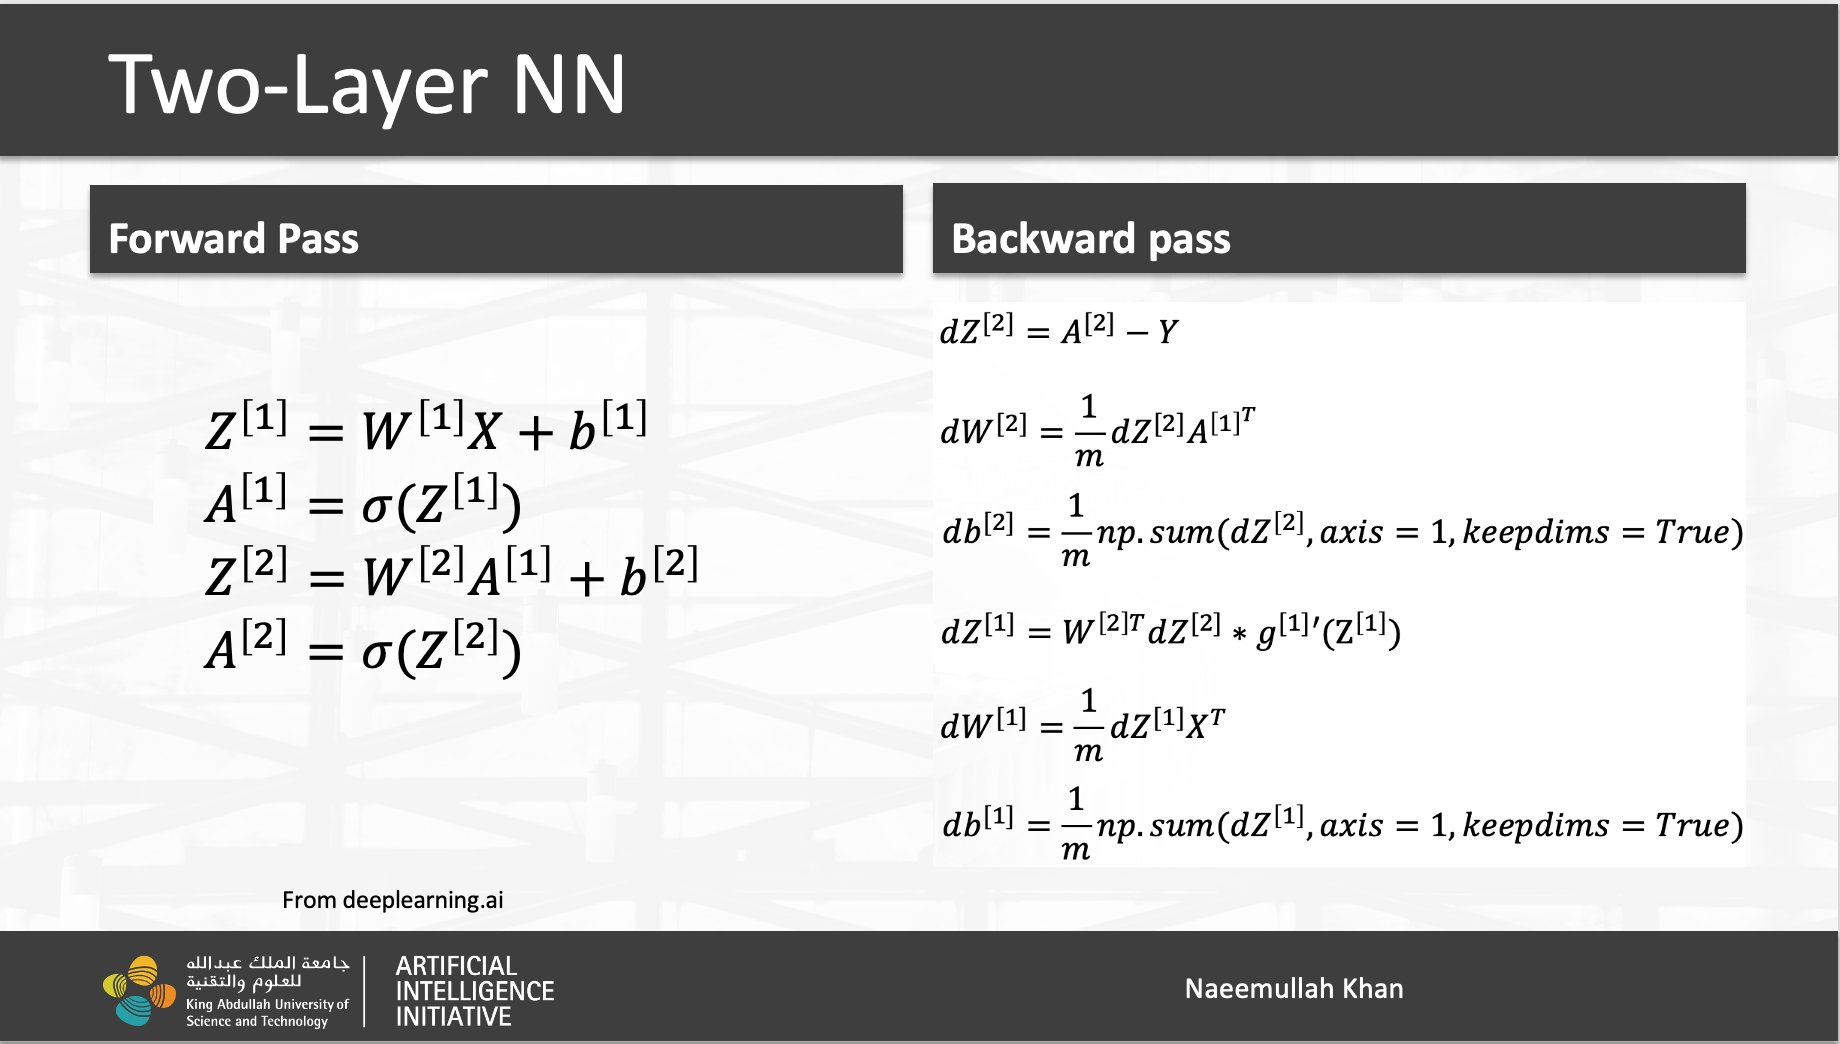

## The main training loop, with batch gradient descent.



### helper functions for the model

In [7]:
def get_z(X, W, b):
  return W@X+b

def sigmoid(Z):
  return 1/(1+np.exp(-Z))

def cross_entropy_loss(yhat, y):
  l = np.mean(np.sum(-y*np.log(yhat), axis = 0))
  return l

### Declare the model

declaring the number of params, the model layers and hyper params (learning rate, number of epochs, etc)

In [11]:
ni = 28*28                   # no of input feature
nh = 50                      # no of hidden units/nodes
no = 10                      # no of out channel (has to be equal ot the number of classes)

W1 = np.random.randn(nh,ni)  # the number of rows of w1 has to equal the of hidden untis and the number of columns have to equal the number of rows of X
b1 = np.zeros((nh , 1))      # b1 is a column vector and the rows have to match z1

W2 = np.random.randn(no ,nh) # the number of rows have to be equal to out channels nad the no of columsn eaul to the number of rows of A1
b2 = np.zeros((no, 1))       # column vector, rows equal to z2

num_epochs = 12
lr = 1e-2
train_epoch_losses = []

total_train_imgs = len(train_loader.dataset)

Pre-training output

In [12]:
epoch_loss = 0
correct = 0

# passing data to the model loop
for X, labels in train_loader:

    # Data
    X = X.numpy().reshape(-1,28*28).T
    labels = labels.numpy()

    y = np.zeros((no, X.shape[1]))
    y[labels, np.arange(y.shape[1])] = 1

    # Forward propagation
    Z1 = W1@X + b1
    A1 = sigmoid(Z1)
    Z2 = W2@A1 + b2
    yhat = sigmoid(Z2)

    # Loss computation and evaluation
    loss = cross_entropy_loss(yhat, y)
    epoch_loss += loss*len(labels)

    pred = np.argmax(yhat, axis = 0)
    correct += np.sum(labels == pred)

epoch_loss /= total_train_imgs
train_epoch_losses.append(epoch_loss)

print(f'loss = {epoch_loss}. {correct}/{total_train_imgs} correctly labelled.')

loss = 1.4276175460310805. 5494/60000 correctly labelled.


### Training loop

In [ ]:
# Loop over epochs
for i in range(num_epochs):

    epoch_loss = 0
    correct = 0

    # Loop over a single batch of data at a time
    for X, labels in train_loader:

        # 1. Preparing the data
        X = X.numpy().reshape(-1,28*28).T
        labels = labels.numpy()

        y = np.zeros((no, X.shape[1]))
        y[labels, np.arange(y.shape[1])] = 1

        # 2. forward pass
        # Layer 1
        Z1 = W1@X + b1
        A1 = sigmoid(Z1)

        # Layer 2
        Z2 = W2@A1 + b2
        yhat = sigmoid(Z2)

        # 3. backward pass
        dZ2 = yhat - y

        dW2 = dZ2 @ A1.T
        db2 = np.sum(dZ2, axis=1, keepdims=True)

        dZ1 = W2.T @ dZ2 * A1*(1-A1)

        dW1 = dZ1 @ X.T
        db1 = np.sum(dZ1, axis=1, keepdims=True)

        # 4. optimization (updating the weights)
        W2 -= lr*dW2
        b2 -= lr*db2
        W1 -= lr*dW1
        b1 -= lr*db1

        # 5. calcuating classification error
        pred = np.argmax(yhat, axis = 0)
        correct += np.sum(labels == pred)

        loss = cross_entropy_loss(yhat, y)
        epoch_loss += loss*len(labels)

    epoch_loss /= total_train_imgs
    train_epoch_losses.append(epoch_loss)

  print(f'Epoch {i}, loss = {epoch_loss}. {correct}/{total_train_imgs} correctly labelled.')

Epoch 0, loss = 0.7778354467509797. 47790/60000 correctly labelled.
Epoch 1, loss = 0.4426743999385747. 53484/60000 correctly labelled.
Epoch 2, loss = 0.3652586209206225. 54708/60000 correctly labelled.
Epoch 3, loss = 0.32015495992144183. 55409/60000 correctly labelled.
Epoch 4, loss = 0.28827913560158813. 55910/60000 correctly labelled.
Epoch 5, loss = 0.2645222729753157. 56308/60000 correctly labelled.
Epoch 6, loss = 0.24610234844530107. 56577/60000 correctly labelled.
Epoch 7, loss = 0.2311059928449062. 56810/60000 correctly labelled.
Epoch 8, loss = 0.21844315628414285. 56986/60000 correctly labelled.
Epoch 9, loss = 0.20764263029798652. 57145/60000 correctly labelled.
Epoch 10, loss = 0.1983964223342897. 57257/60000 correctly labelled.
Epoch 11, loss = 0.19030633818437334. 57381/60000 correctly labelled.


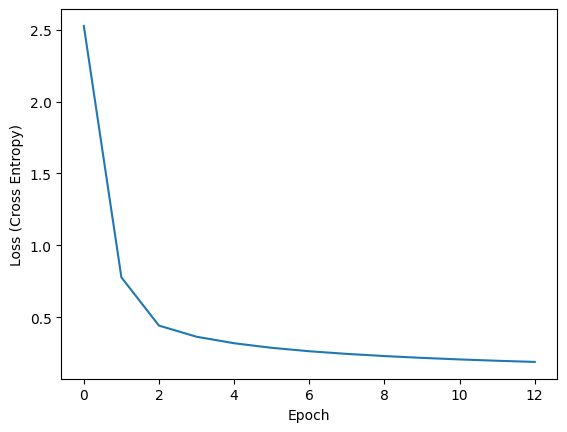

In [ ]:
plt.plot(train_epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.show()